# <font color = 'Purple'>**Multilabel Generation with QWEN.2-3B-instruction-tuned**

The purpose of this notebook is to finetune the **QWEN** model for emotion detection on a small dataset.

- Based on my past experiences using both RNN and BERT models, I plan on using a similar strategy to account for the class imbalance present in this dataset.

- This will be done using **K-fold stratified sampling** to create my splits such that the class distribution represents that of the training set.

- Instead of modifying the architecture by replacing the language head with a classification head, I will **retain the language head** of the instruction-tuned model and use it to generate the emotion labels directly.

- The training will follow a standard model training process as shown below.

---

## <font color = 'purple'>**Training Plan**

1. **Set the Environment**

2. **Load the Dataset**

3. **Manipulate the Splits of the Dataset**
   - Use stratified K-fold sampling to maintain class balance in splits.

4. **Load the Pretrained Tokenizer**

5. **Create a Function for the Tokenizer**
  - 5.1 Filtering Long Sequences
  - 5.2 Data Collator

6. **Train the Model**
   - 6.1. Download the model
   - 6.2. PEFT Setup
   - 6.3. Define Training Arguments
   - 6.4. Instantiate the Trainer
   - 6.5. Setup Weights & Biases (WANDB)
   - 6.6. Training and Validation
   - 6.7. Generate labels using the **instruction-tuned language head**.

7. **Model Inference**

# <font color='purple'>**1. Set the Environment**

<font color = 'purple'>***Setting this up for RunPod***

In [1]:
# Adaptable setup
import os

# Check if running on Colab or local environment
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    base_path = '/content/drive/MyDrive/Colab Notebooks'
    
    # Install necessary packages
    print("Installing required libraries...")
    !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl -U -qq
    !pip install iterative-stratification -qq

else:
    base_path = '/workspace'
    os.makedirs(base_path, exist_ok=True)

    # Install necessary packages
    print("Installing required libraries...")
    !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl -U -qq
    !pip install iterative-stratification -qq

# Set cache directories for Hugging Face and PyTorch
os.environ['HF_HOME'] = '/sys/fs/cgroup/huggingface_cache'
os.environ['TORCH_HOME'] = '/sys/fs/cgroup/torch_cache'

# Create directories if they do not exist
os.makedirs(os.environ['HF_HOME'], exist_ok=True)
os.makedirs(os.environ['TORCH_HOME'], exist_ok=True)

# Print confirmation
print(f"Base path is set to: {base_path}")
print("HF_HOME set to:", os.environ['HF_HOME'])
print("TORCH_HOME set to:", os.environ['TORCH_HOME'])

Installing required libraries...
Base path is set to: /workspace
HF_HOME set to: /sys/fs/cgroup/huggingface_cache
TORCH_HOME set to: /sys/fs/cgroup/torch_cache


In [2]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time
from typing import Dict, List, Union, Optional, Tuple
import json
import itertools
from datetime import datetime
from difflib import get_close_matches
import os
import sys
from dotenv import load_dotenv

from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast
from tqdm import tqdm

# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from huggingface_hub import login

In [3]:
%load_ext autoreload
%autoreload 2

### <font color = 'purple'>***Setting up wandb and hf login for colab and other locations via the .env file***

In [4]:
base_folder = Path(base_path)

In [5]:
def is_colab() -> bool:
    """Check if the current environment is Google Colab."""
    return 'google.colab' in sys.modules

def get_env_file_path() -> str:
    """
    Get the path to your .env file
    Modify this function to point to your .env file location
    """

    env_path = str(base_folder / 'env')

    return env_path

def get_credentials() -> Tuple[Optional[str], Optional[str]]:
    """Get credentials from either Colab or local environment."""
    wandb_api_key = None
    hf_token = None

    if is_colab():
        try:
            from google.colab import userdata
            wandb_api_key = userdata.get('WANDB_API_KEY')
            hf_token = userdata.get('HF_TOKEN')
            print("Using Google Colab environment")
        except Exception as e:
            print(f"Error accessing Colab userdata: {e}")
    else:
        # Try to load from .env file in specified location
        try:
            from dotenv import load_dotenv
            env_path = get_env_file_path()
            if os.path.exists(env_path):
                load_dotenv(env_path)
                print(f"Loaded .env file from: {env_path}")
            else:
                print(f"Warning: .env file not found at {env_path}")
        except ImportError:
            print("python-dotenv not installed. Using environment variables directly.")
        except Exception as e:
            print(f"Error loading .env file: {e}")

        wandb_api_key = os.getenv('WANDB_API_KEY')
        hf_token = os.getenv('HF_TOKEN')

    return wandb_api_key, hf_token

def setup_auth():
    """Setup authentication for both environments."""
    wandb_api_key, hf_token = get_credentials()

    # Hugging Face authentication
    if hf_token:
        try:
            from huggingface_hub import login
            login(token=hf_token)
            print("✓ Successfully logged in to Hugging Face!")
        except Exception as e:
            print(f"✗ Error logging in to Hugging Face: {e}")
    else:
        print("✗ Hugging Face token not found.")
        if is_colab():
            print("  Add HF_TOKEN to your Colab secrets")
        else:
            print(f"  Add HF_TOKEN to your .env file at {get_env_file_path()}")

    # Weights & Biases authentication
    if wandb_api_key:
        try:
            import wandb
            wandb.login(key=wandb_api_key)
            print("✓ Successfully logged in to WANDB!")
        except Exception as e:
            print(f"✗ Error logging in to WANDB: {e}")
    else:
        print("✗ WANDB API key not found.")
        if is_colab():
            print("  Add WANDB_API_KEY to your Colab secrets")
        else:
            print(f"  Add WANDB_API_KEY to your .env file at {get_env_file_path()}")

setup_auth()

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Loaded .env file from: /workspace/env
✓ Successfully logged in to Hugging Face!


wandb: Currently logged in as: the-steven-e (the-steven-e-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


✓ Successfully logged in to WANDB!


# <font color='purple'>**2. Load the Dataset**

In [9]:
# Setting up paths
base_folder = Path(base_path)
data_folder = base_folder/'datasets/emotion_datasets'
model_folder = Path('/sys/fs/cgroup/models/qwen-14B-it')

# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
data_folder.mkdir(exist_ok = True, parents =True)


In [10]:
train_valid_df = pd.read_csv(data_folder/'train.csv')
train_valid_df.head(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [11]:
train_val_labels = train_valid_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

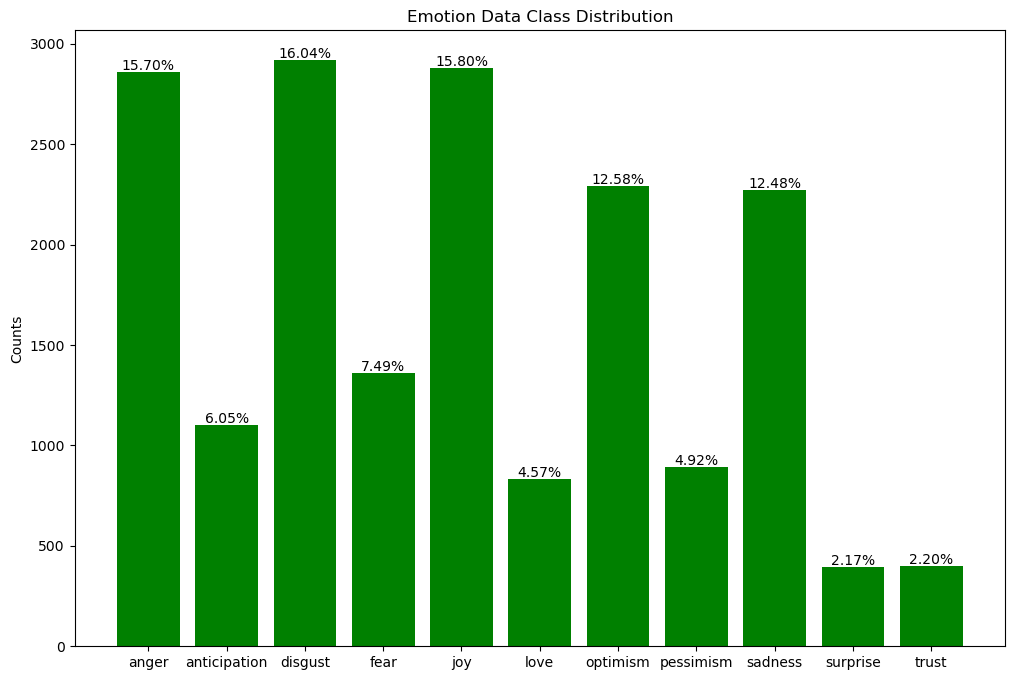

In [12]:
# getting the count for the labels
label_counts = train_val_labels.sum()
#getting the count overall
total_count = label_counts.sum()
# getting the percentages
percentages = (label_counts/total_count)*100

plt.figure(figsize = (12,8))
plt.bar(label_counts.index, label_counts.values, color = 'green')

for i , (count, pct) in enumerate(zip(label_counts.values, percentages)):
  plt.text(i, count+10, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Data Class Distribution')
plt.ylabel('Counts')
plt.show()

# <font color='purple'>**3. Manipulate the Splits of the Dataset**

In [13]:
mkf = MultilabelStratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

X = train_valid_df['Tweet'].values
y = train_val_labels.values

for train_index, valid_index in mkf.split(X, y):
  X_train, X_val = X[train_index], X[valid_index]
  y_train, y_val = y[train_index], y[valid_index]

In [14]:
train_df = train_valid_df.iloc[train_index] # pulling the training indices from the split
val_df = train_valid_df.iloc[valid_index] # pulling the valid indices from the split

In [15]:
train_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [16]:
val_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
6,2017-20221,Do you think humans have the sense for recogni...,0,1,0,0,0,0,0,1,0,0,0
25,2017-11184,What a fucking muppet. @jRwild1 #stalker.,1,0,1,0,0,0,0,0,0,0,0
28,2017-21740,@FaithHill I remember it well #happy #afraid #...,0,0,0,1,1,1,1,0,0,0,0
31,2017-21716,@WaterboysAS I would never strategically vote ...,1,0,1,1,0,0,0,0,0,0,0
39,2017-21752,@imtarakate Uggh that's really horrible. You'r...,0,0,1,1,0,0,1,0,0,0,1


In [17]:
train_labels = train_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

In [18]:
train_labels.sum()

anger           2574
anticipation     991
disgust         2629
fear            1226
joy             2589
love             749
optimism        2062
pessimism        805
sadness         2046
surprise         356
trust            360
dtype: int64

<font color = 'purple'>***Plotting the training and validation class distributions to check the split.***

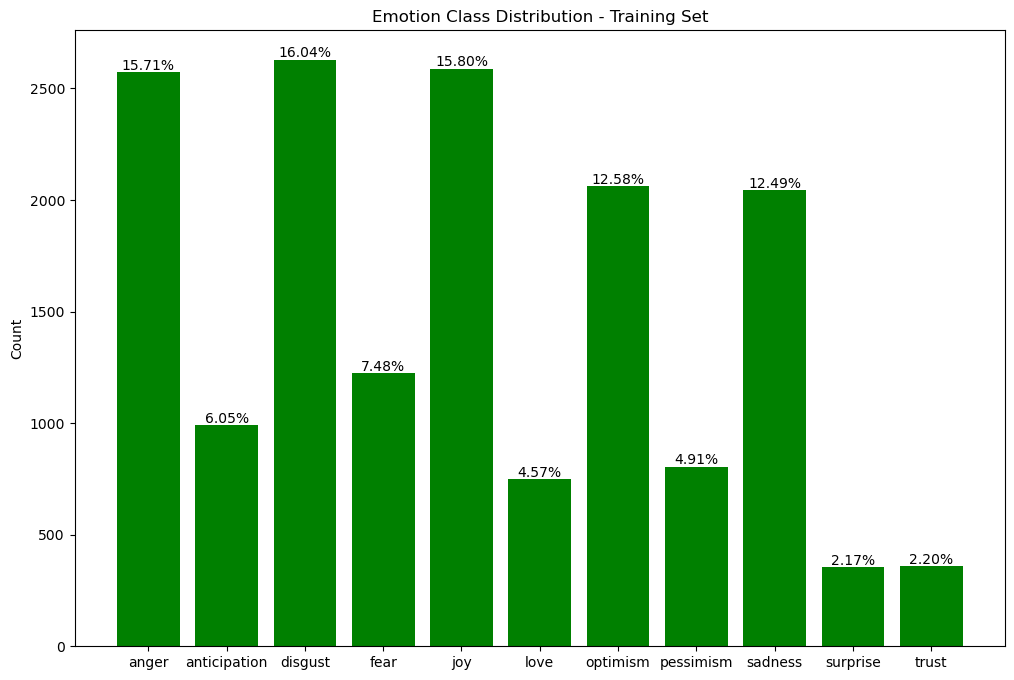

In [19]:
label_counts_t = train_labels.sum()

total_count_t = label_counts_t.sum()

percentages = (label_counts_t/total_count_t)*100

plt.figure(figsize = (12,8))
plt.bar(label_counts_t.index, label_counts_t.values, color = 'green')

for i, (count, pct) in enumerate(zip(label_counts_t.values, percentages)):
  plt.text(i, count+10, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution - Training Set')
plt.ylabel('Count')
plt.show()

In [20]:
val_labels = val_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

In [21]:
val_labels.sum()

anger           285
anticipation    111
disgust         292
fear            137
joy             288
love             83
optimism        229
pessimism        90
sadness         227
surprise         40
trust            40
dtype: int64

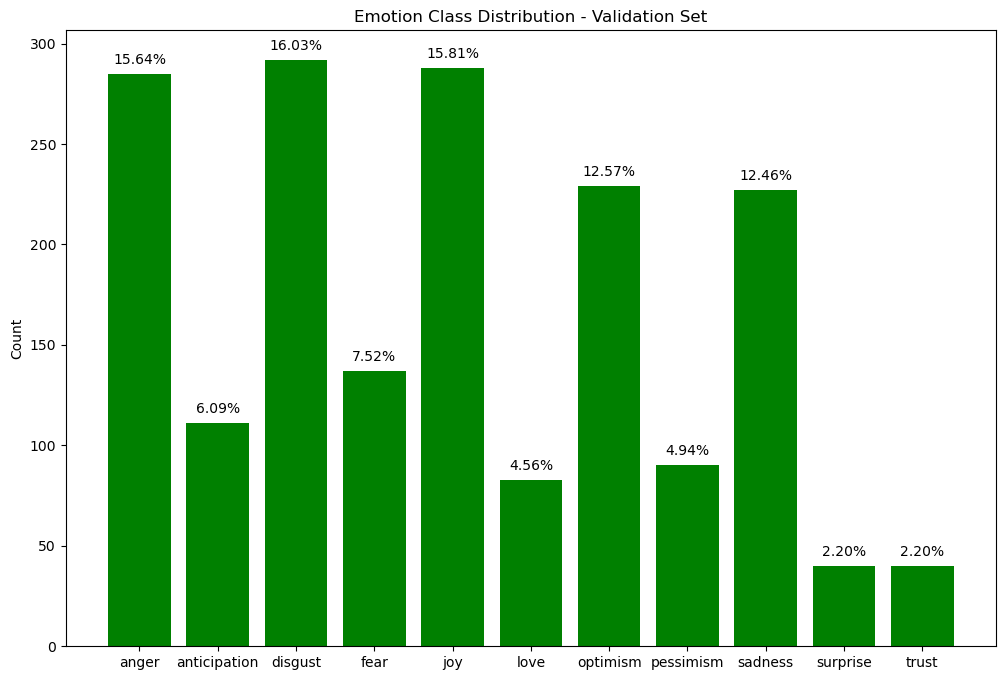

In [22]:
# plotting to see the distribution for the validation set
label_counts_v = val_labels.sum()

total_counts_v = label_counts_v.sum()

percentages = (label_counts_v/total_counts_v)*100

plt.figure(figsize = (12,8))
plt.bar(label_counts_v.index, label_counts_v.values, color = 'green')

for i, (count, pct) in enumerate(zip(label_counts_v.values, percentages)):
  plt.text(i, count+5, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution - Validation Set')
plt.ylabel('Count')
plt.show()

In [23]:
type(X_train)

numpy.ndarray

In [24]:
type(y_train)

numpy.ndarray

In [25]:
X_train = X_train.tolist()
X_val = X_val.tolist()

In [26]:
X_train[0]

"“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry"

In [27]:
y_train[0]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [28]:
class_names = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
# Map the binary array to class names
def map_binary_to_classes(binary_array, class_names):
    # Iterate through each sample (row) in the binary array
    mapped_samples = []
    for sample in binary_array:
        mapped_samples.append([class_names[i] for i in range(len(sample)) if sample[i] == 1])
    return mapped_samples

# Apply the mapping
y_train_mapped = map_binary_to_classes(y_train, class_names)
y_val_mapped = map_binary_to_classes(y_val, class_names)

print(f"Mapped y_train: {y_train_mapped}")
print(f"Mapped y_val: {y_val_mapped}")

In [30]:
trainset = Dataset.from_dict(
    {
    'text':X_train,
    'label':y_train_mapped
    })
validset = Dataset.from_dict({
    'text': X_val,
    'label':y_val_mapped
})

In [31]:
trainset[0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': ['anticipation', 'optimism', 'trust']}

In [32]:
validset[0]

{'text': 'Do you think humans have the sense for recognizing impending doom? ',
 'label': ['anticipation', 'pessimism']}

In [33]:
# compiling the trainset and validset into another dataset
train_val = DatasetDict({'train':trainset, 'valid':validset})

In [34]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 773
    })
})

In [35]:
train_val['train'][0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': ['anticipation', 'optimism', 'trust']}

In [36]:
train_val['valid'][0]

{'text': 'Do you think humans have the sense for recognizing impending doom? ',
 'label': ['anticipation', 'pessimism']}

# <font color='purple'>**4. Load the Pretrained Tokenizer**

In [37]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")

In [38]:
free_gpu_memory()

GPU memory has been freed.


In [40]:
checkpoint = 'Qwen/Qwen2.5-Coder-14B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [41]:
tokenizer.eos_token

'<|im_end|>'

In [42]:
tokenizer.pad_token

'<|endoftext|>'

In [43]:
tokenizer.padding_side

'right'

In [44]:
tokenizer.chat_template

'{%- if tools %}\n    {{- \'<|im_start|>system\\n\' }}\n    {%- if messages[0][\'role\'] == \'system\' %}\n        {{- messages[0][\'content\'] }}\n    {%- else %}\n        {{- \'You are Qwen, created by Alibaba Cloud. You are a helpful assistant.\' }}\n    {%- endif %}\n    {{- "\\n\\n# Tools\\n\\nYou may call one or more functions to assist with the user query.\\n\\nYou are provided with function signatures within <tools></tools> XML tags:\\n<tools>" }}\n    {%- for tool in tools %}\n        {{- "\\n" }}\n        {{- tool | tojson }}\n    {%- endfor %}\n    {{- "\\n</tools>\\n\\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\\n<tool_call>\\n{\\"name\\": <function-name>, \\"arguments\\": <args-json-object>}\\n</tool_call><|im_end|>\\n" }}\n{%- else %}\n    {%- if messages[0][\'role\'] == \'system\' %}\n        {{- \'<|im_start|>system\\n\' + messages[0][\'content\'] + \'<|im_end|>\\n\' }}\n    {%- else %}\n       

# <font color='purple'>**5. Create prompts**

In [45]:
class_names

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [46]:
def format_chat(example):
    instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}.\n\nTEXT: {example['text']}"
    messages = [
        {"role": "user", "content": instruction},
        {"role": "assistant", "content": f"{example['label']}"}
    ]
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False)}

In [47]:
train_val_subset_chat = train_val.map(format_chat)

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [48]:
train_val_subset_chat

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 773
    })
})

In [49]:
train_val_subset_chat['train'][0]

{'text': "<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: “Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry<|im_end|>\n<|im_start|>assistant\n['anticipation', 'optimism', 'trust']<|im_end|>\n",
 'label': ['anticipation', 'optimism', 'trust']}

## <font color='purple'>**5.1 Filter Long Sequences**

In [50]:
def check_length(example):
   encoding = tokenizer.encode(example['text'])
   return len(encoding) <= 1000

train_filtered = train_val_subset_chat['train'].filter(check_length)
valid_filtered = train_val_subset_chat['valid'].filter(check_length)

print(f"Train: {len(train_val_subset_chat['train'])} -> {len(train_filtered)}")
print(f"Valid: {len(train_val_subset_chat['valid'])} -> {len(valid_filtered)}")

Filter:   0%|          | 0/6951 [00:00<?, ? examples/s]

Filter:   0%|          | 0/773 [00:00<?, ? examples/s]

Train: 6951 -> 6951
Valid: 773 -> 773


# <font color='purple'>**6. Train the Model**

## <font color='purple'>**6.1 Download the Model**

In [51]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [52]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [53]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [54]:
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                            )

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/47.5k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/4.73G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

## <font color='purple'>**6.2 PEFT setup**

In [55]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 5120)
    (layers): ModuleList(
      (0-47): 48 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=True)
          (k_proj): Linear4bit(in_features=5120, out_features=1024, bias=True)
          (v_proj): Linear4bit(in_features=5120, out_features=1024, bias=True)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((5120,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((5120,), eps=1e

In [56]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [57]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head']


['gate_proj',
 'k_proj',
 'o_proj',
 'up_proj',
 'down_proj',
 'q_proj',
 'lm_head',
 'v_proj']

In [58]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [59]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 550,502,400 || all params: 15,320,536,064 || trainable%: 3.5932


## <font color='purple'>**6.3 Define Training Arguments**

In [60]:
run_name = 'QWEN-14B-it-emotion-exp1'
use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = SFTConfig(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=3,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=100,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=100,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # A model is 'better' if its accuracy is higher
    lr_scheduler_type = 'linear', # linear learning rate scheduler
    warmup_steps = 200, #200 warmup steps


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)

In [61]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model.config.use_cache = False  # Disable caching for compatibility

model.config

Qwen2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2.5-Coder-14B-Instruct",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 5120,
  "initializer_range": 0.02,
  "intermediate_size": 13824,
  "max_position_embeddings": 32768,
  "max_window_layers": 48,
  "model_type": "qwen2",
  "num_attention_heads": 40,
  "num_hidden_layers": 48,
  "num_key_value_heads": 8,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
 

## <font color='purple'>**6.4 Instantiate the Trainer**

In [62]:
# pushing the model to the gpu to prep for training
data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False,
                                                      response_template="<|im_start|>assistant\n")
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_filtered,
    eval_dataset=valid_filtered,

    peft_config=peft_config,
    packing=False,
    data_collator=data_collator_comp,

)

/root/miniconda/envs/colab_env/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

## <font color='purple'>**6.5 Setup Weights & Biases (WANDB)**

In [63]:
%env WANDB_PROJECT = qwen_14B_it_multilabel

env: WANDB_PROJECT=qwen_14B_it_multilabel


## <font color='purple'>**6.6 Training and Validation**

In [64]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e

Step,Training Loss,Validation Loss
100,0.356600,0.286029
200,0.278100,0.273715
300,0.259700,0.258845
400,0.246000,0.260853
500,0.220900,0.268843
600,0.200900,0.267495


In [65]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [66]:
best_model_checkpoint_step

'300'

In [68]:
from peft import AutoPeftModelForCausalLM, PeftConfig

In [69]:
model_folder = model_folder
best_model_checkpoint_step
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             )
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.padding_side = 'left'

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [70]:
def format_chat_inference(example):
    instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}.\n\nTEXT: {example['text']}"
    messages = [
        {"role": "user", "content": instruction},
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return {"text": text}

In [72]:
valid_subset= train_val['valid'].map(format_chat_inference)

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [73]:
valid_filtered = valid_subset.filter(check_length)

Filter:   0%|          | 0/773 [00:00<?, ? examples/s]

In [74]:
valid_filtered['text'][0]

"<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: Do you think humans have the sense for recognizing impending doom? <|im_end|>\n<|im_start|>assistant\n"

In [75]:
free_gpu_memory()

GPU memory has been freed.


## <font color='purple'>**6.7 Generate Labels Using the Instruction-Tuned Language Head**

In [77]:
def run_inference_instruction(
    seed: int,
    dataset: Union[Dict, List],
    model,
    tokenizer,
    per_device_batch_size: int,
    input_field: str,
    output_field: str,
    save_dir: Optional[Path] = None,
    save_file_name: Optional[str] = None,
    max_new_tokens: int = 20,
    num_beams: int = 1,
    do_sample: bool = False,
    top_k: int = 50,
    top_p: float = 1.0,
    temperature: float = 1.0,
    no_repeat_ngram_size: int = 2,
    num_return_sequences: int = 1
) -> List[Dict]:

    """
    Run inference on a dataset and return complete generations.

    Args:
        seed: Random seed for reproducibility
        dataset: Input dataset (dict or list)
        model: The model to use for inference
        tokenizer: The tokenizer to use
        per_device_batch_size: Batch size for inference
        prompt_template: Template for formatting prompts
        input_field: Field name for input text in dataset
        output_delimiter: Delimiter used in prompt template
        save_path: Optional path to save generations
        ... (generation parameters)

    Returns:
        List of dictionaries containing input, complete generation, and labels
    """

    set_seed(seed)
    model.eval()
    device = model.device
    batch_size = per_device_batch_size
    inference_results = []


    progress_bar = tqdm(range(0, len(dataset), batch_size), desc="Generating predictions")

    for i in progress_bar:
       batch = dataset[i:i + batch_size]

       try:
           texts = batch[input_field]
           labels = batch[output_field] if output_field in batch else ["N/A"] * len(texts)


           inputs = tokenizer(texts, return_tensors="pt", padding=True)
           inputs = {k: v.to(device) for k, v in inputs.items()}

           with torch.no_grad():
               outputs = model.generate(
                   **inputs,
                   max_new_tokens=max_new_tokens,
                   num_beams=num_beams,
                   do_sample=do_sample,
                   top_k=top_k,
                   top_p=top_p,
                   temperature=temperature,
                   pad_token_id=tokenizer.pad_token_id,
               )

           decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=False)

           for text, label, decoded_output in zip(texts, labels, decoded_outputs):
                   inference_results.append({
                    "input": text,
                    "generated_output": decoded_output,
                    "ground_truth": label
                })


       except Exception as e:
           print(f"Error processing batch: {str(e)}")
           continue
    # Save generations if path provided
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        # If no filename provided, create a timestamped one
        if save_file_name is None:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_name = f"generations_{timestamp}.json"
        elif not save_file_name.endswith('.json'):
            save_name = f"{save_file_name}.json"

        save_file = save_dir / save_name

        with open(save_file, 'w') as f:
            json.dump(inference_results, f, indent=2)
        print(f"Saved inference_results to: {save_file}")

    return inference_results

In [78]:
free_gpu_memory()

GPU memory has been freed.


In [79]:
valid_inference_results = run_inference_instruction(seed = 42,
                                                    dataset = valid_filtered,
                                                    model = model,
                                                    tokenizer = tokenizer,
                                                    per_device_batch_size = 50,
                                                    input_field = 'text',
                                                    output_field = 'label',
                                                    save_dir = model_folder,
                                                    save_file_name = 'valid_complete_generations')

Generating predictions: 100%|██████████| 16/16 [01:08<00:00,  4.26s/it]

Saved inference_results to: /sys/fs/cgroup/models/qwen-72B-it/valid_complete_generations.json


In [80]:
valid_inference_results[1]['generated_output']

"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: What a fucking muppet.  @jRwild1  #stalker.<|im_end|>\n<|im_start|>assistant\n['anger', 'disgust']<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>"

In [81]:
output_delimiter = "<|im_start|>assistant"
def extract_content(generated_output: str, output_delimiter: str) -> str:
    """
    Extract content after delimiter from a generated output string.

    Args:
        generated_output: String containing the complete model generation
        output_delimiter: Delimiter to extract content after

    Returns:
        Extracted content as string, or None if delimiter not found
    """
    pattern = f'{re.escape(output_delimiter.strip())}\\s*(.*?)(?:<\\|im_end\\|>)'
    match = re.search(pattern, generated_output, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return None

In [82]:
valid_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in valid_inference_results]

In [83]:
valid_extracted_outputs[0]

"['anticipation', 'fear', 'pessimism']"

In [84]:
# getting the first 20 generated outputs
for i in range(20):
  print(valid_extracted_outputs[i])

['anticipation', 'fear', 'pessimism']
['anger', 'disgust']
['fear', 'joy', 'optimism']
['anger', 'disgust', 'fear']
['anger', 'disgust', 'fear', 'sadness']
['optimism', 'trust']
['anger', 'anticipation', 'joy']
['anticipation', 'joy', 'optimism']
['joy', 'optimism']
['pessimism', 'sadness']
['joy', 'love', 'optimism']
['joy', 'optimism']
['anticipation', 'joy', 'optimism']
['anger', 'disgust', 'fear', 'sadness']
['anticipation', 'joy', 'optimism', 'trust']
['anger', 'disgust', 'joy']
['fear']
['anger', 'disgust']
['joy', 'love', 'sadness']
['joy', 'optimism']


In [85]:
# getting the first 20 ground truth labels for comparison
for i in range(20):
  print(valid_inference_results[i]['ground_truth'])

['anticipation', 'pessimism']
['anger', 'disgust']
['fear', 'joy', 'love', 'optimism']
['anger', 'disgust', 'fear']
['disgust', 'fear', 'optimism', 'trust']
['anger', 'optimism']
['anger']
['joy', 'optimism']
['joy', 'optimism']
['sadness']
['joy', 'love']
['anger', 'disgust', 'sadness']
['anticipation', 'joy', 'optimism', 'surprise']
['anticipation']
['anger', 'anticipation', 'disgust', 'optimism']
['anger', 'disgust', 'joy', 'optimism']
['anger', 'disgust', 'fear']
['anger', 'disgust', 'pessimism']
['joy', 'love', 'sadness']
['anticipation', 'joy', 'optimism']


In [88]:
def clean_and_split_labels(extracted_output: str, class_names: List[str], cutoff: float = 0.6) -> List[str]:
    """
    Clean and normalize extracted content for multi-label classification.

    Args:
        extracted_output: String containing extracted labels
        class_names: List of valid class names
        cutoff: Threshold for fuzzy matching

    Returns:
        List of cleaned and normalized labels
    """
    from difflib import get_close_matches

    # Convert to string if not already
    if isinstance(extracted_output, (list, tuple)):
        label_set = ' '.join(str(x) for x in extracted_output)
    else:
        label_set = str(extracted_output)

    # Basic cleaning
    label_set = label_set.lstrip('=')
    # Remove various bracket and quote combinations
    label_set = label_set.replace('=["', '').replace('["', '').replace('"]', '')
    label_set = label_set.replace("['", '').replace("']", '')
    label_set = label_set.replace('("', '').replace('")', '')
    label_set = label_set.replace('(["', '').replace('"])', '')
    label_set = label_set.replace('([', '').replace('])', '')
    label_set = label_set.replace('[', '').replace(']', '')
    label_set = label_set.replace('(', '').replace(')', '')
    label_set = label_set.replace('"', '').replace("'", '')

    # Handle multiple types of separators
    label_set = ' '.join(label_set.split())  # normalize spaces
    raw_labels = label_set.split(',') if ',' in label_set else label_set.split()

    # Clean and normalize labels
    raw_labels = [label.strip().lower() for label in raw_labels if label.strip()]

    # Match to valid classes using fuzzy matching
    cleaned_labels = []
    for label in raw_labels:
        if label in class_names:
            cleaned_labels.append(label)
        else:
            matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
            if matches:
                cleaned_labels.append(matches[0])

    # Remove duplicates while preserving order
    seen = set()
    cleaned_labels = [x for x in cleaned_labels if not (x in seen or seen.add(x))]

    return cleaned_labels


In [89]:
    class_names = ['anger',
                    'anticipation',
                    'disgust',
                    'fear',
                    'joy',
                    'love',
                    'optimism',
                    'pessimism',
                    'sadness',
                    'surprise',
                    'trust']

In [90]:
valid_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in valid_extracted_outputs
]

valid_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in valid_inference_results
]

# initialize the MultLabelBinarizer with the known classes
mlb = MultiLabelBinarizer(classes = class_names)
mlb.fit(class_names) # fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Print samples and shapes
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

Sample of true labels: [['anticipation', 'pessimism'], ['anger', 'disgust'], ['fear', 'joy', 'love', 'optimism'], ['anger', 'disgust', 'fear'], ['disgust', 'fear', 'optimism', 'trust']]
Sample of predictions: [['anticipation', 'fear', 'pessimism'], ['anger', 'disgust'], ['fear', 'joy', 'optimism'], ['anger', 'disgust', 'fear'], ['anger', 'disgust', 'fear', 'sadness']]

Binary format:
Labels shape: (773, 11)
Predictions shape: (773, 11)


### <font color='purple'>**6.7.2 Define the compute metrics function**

In [91]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [92]:
valid_results = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [93]:
valid_results

{'f1_micro': 0.7239459029435164,
 'f1_macro': 0.6228617218970677,
 'accuracy_label': 0.8775726214277314,
 'accuracy_all': 0.258732212160414}

In [94]:
wandb.log({"valid_f1_macro": valid_results["f1_macro"]})

<font color = 'purple'>***Simple Confusion Matrix***

In [95]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

[[[429  59]
  [ 42 243]]

 [[606  56]
  [ 63  48]]

 [[395  86]
  [ 63 229]]

 [[586  50]
  [ 28 109]]

 [[414  71]
  [ 35 253]]

 [[645  45]
  [ 25  58]]

 [[447  97]
  [ 20 209]]

 [[632  51]
  [ 48  42]]

 [[495  51]
  [ 75 152]]

 [[724   9]
  [ 22  18]]

 [[724   9]
  [ 36   4]]]


In [97]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Greens',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Greens')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats

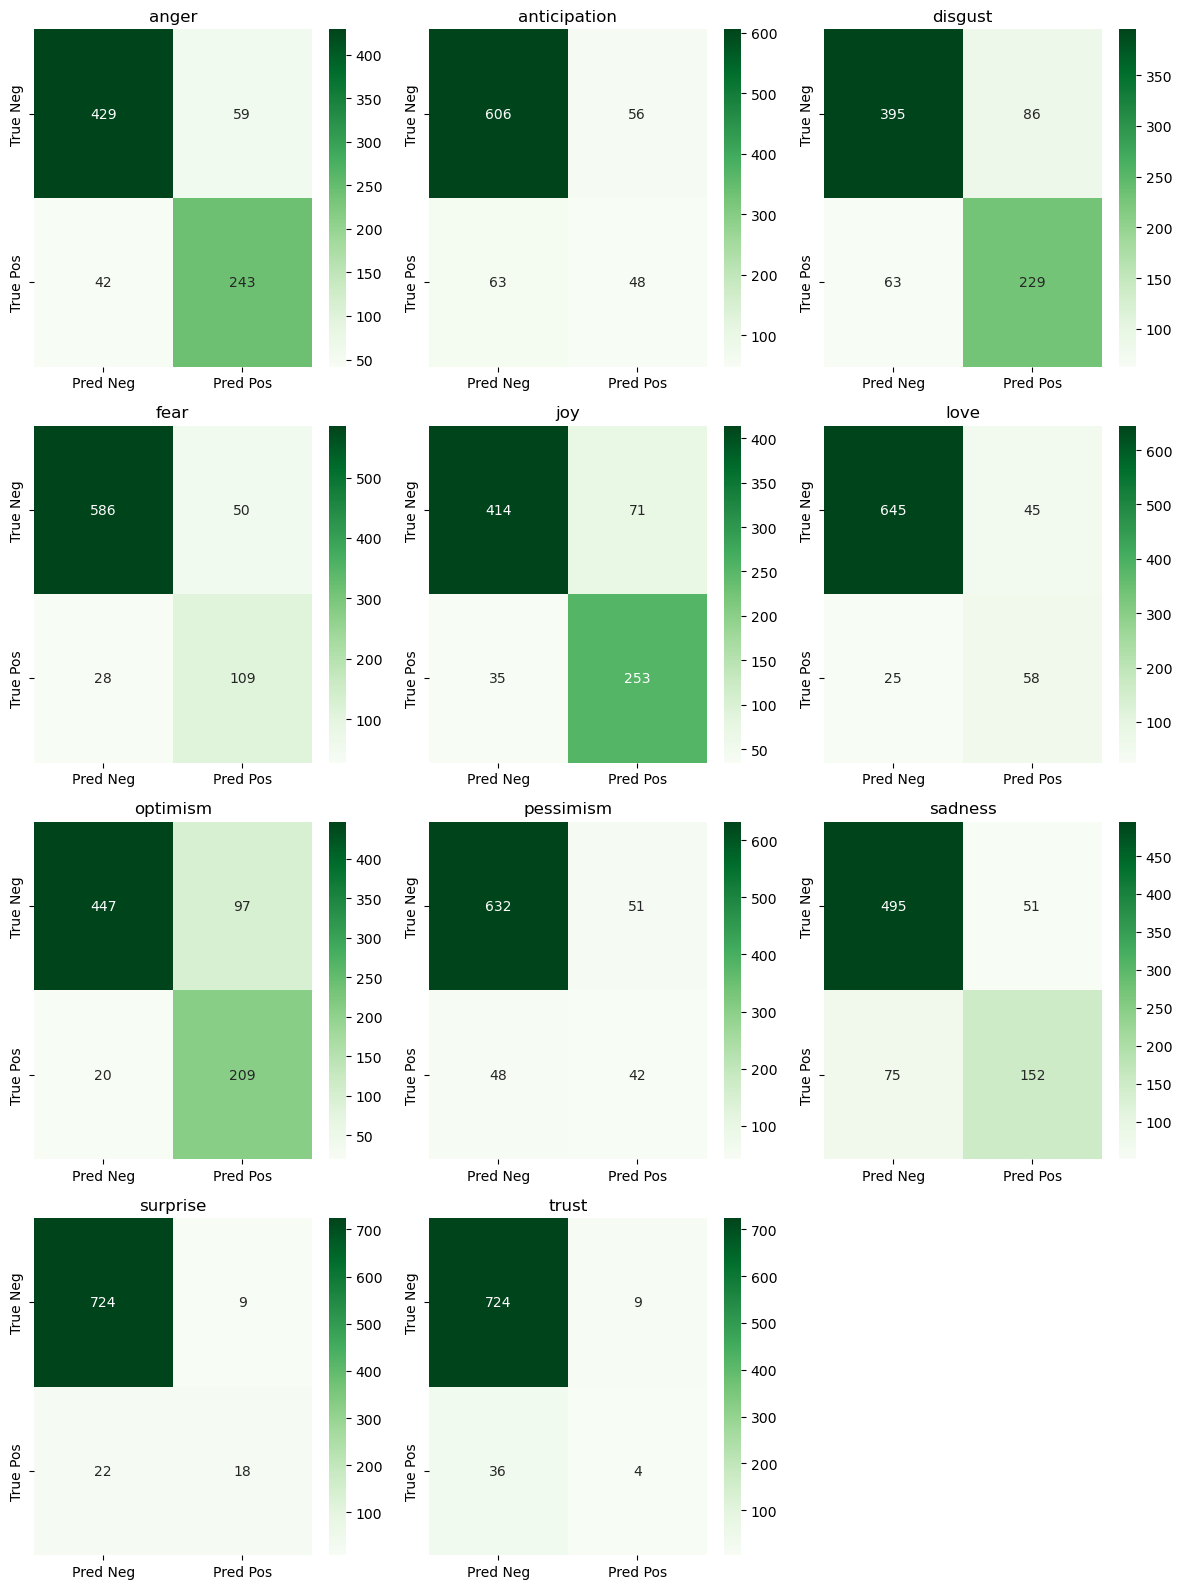

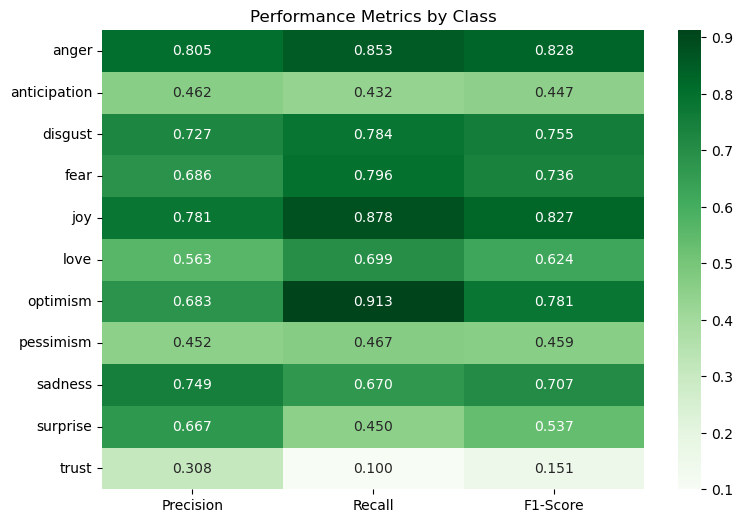

<Figure size 1200x533.333 with 0 Axes>

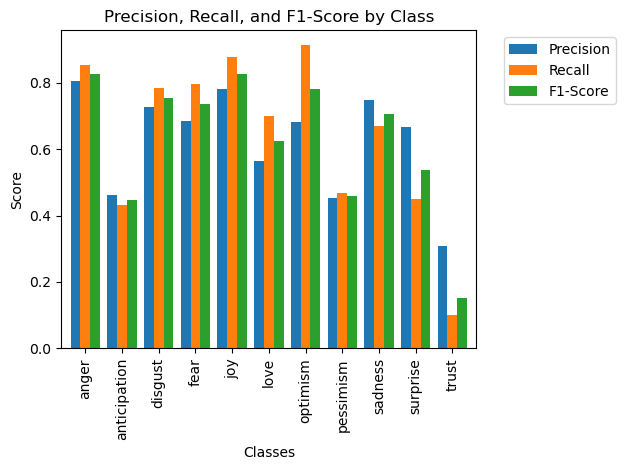

{'macro_avg': {'precision': 0.6254918928539298,
  'recall': 0.6401029430888946,
  'f1': 0.6228617218970677},
 'per_class': {'Precision': {'anger': 0.804635761589404,
   'anticipation': 0.46153846153846156,
   'disgust': 0.726984126984127,
   'fear': 0.6855345911949685,
   'joy': 0.7808641975308642,
   'love': 0.5631067961165048,
   'optimism': 0.6830065359477124,
   'pessimism': 0.45161290322580644,
   'sadness': 0.7487684729064039,
   'surprise': 0.6666666666666666,
   'trust': 0.3076923076923077},
  'Recall': {'anger': 0.8526315789473684,
   'anticipation': 0.43243243243243246,
   'disgust': 0.7842465753424658,
   'fear': 0.7956204379562044,
   'joy': 0.8784722222222222,
   'love': 0.6987951807228916,
   'optimism': 0.9126637554585153,
   'pessimism': 0.4666666666666667,
   'sadness': 0.6696035242290749,
   'surprise': 0.45,
   'trust': 0.1},
  'F1-Score': {'anger': 0.82793867120954,
   'anticipation': 0.44651162790697674,
   'disgust': 0.7545304777594728,
   'fear': 0.73648648648648

In [98]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=class_names, figsize=(12, 8))

# <font color='purple'>**7. Model Inference**

In [99]:
# loading in the test data
test_ds = joblib.load(data_folder/'X_test_cleaned.pkl')

In [100]:
test_df = pd.DataFrame(test_ds).T # transposing
test_df.rename(columns = {0:'text', 1:'label'}, inplace = True)
print(test_df.head())
print("-"*30)
print(test_df.shape)
print('There are no labels for the entire test set.')

                                                text  \
0  @Adnan__786__ @AsYouNotWish Dont worry Indian ...   
1  Academy of Sciences, eschews the normally sobe...   
2                  I blew that opportunity -__- #mad   
3             This time in 2 weeks I will be 30... 😥   
4  #Deppression is real. Partners w/ #depressed p...   

                                               label  
0  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
1  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
2  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
3  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
4  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
------------------------------
(3259, 2)
There are no labels for the entire test set.


In [101]:
test_ids = joblib.load(data_folder/'test_ids.pkl')
test_ids.head()

0    2018-01559
1    2018-03739
2    2018-00385
3    2018-03001
4    2018-01988
Name: ID, dtype: object

In [102]:
test_ds = test_df.drop(columns = {'label'}) # dropping the missing labels from the dataset

In [104]:
import random

In [105]:
# Function to assign random non-duplicate labels to each text
def assign_random_labels(class_names, max_labels=3):
    """Assign a random subset of non-duplicate labels."""
    num_labels = random.randint(1, max_labels)  # Randomly decide how many labels to assign
    return random.sample(class_names, num_labels)

test_ds['label'] = [assign_random_labels(class_names) for _ in range(len(test_ds))]


In [106]:
test_ds

,text,label
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,"[anticipation, anger, joy]"
1,"Academy of Sciences, eschews the normally sobe...",[fear]
2,I blew that opportunity -__- #mad,[anticipation]
3,This time in 2 weeks I will be 30... 😥,"[sadness, anticipation, optimism]"
4,#Deppression is real. Partners w/ #depressed p...,[anger]
...,...,...
3254,shaft abrasions from panties merely shifted to...,[trust]
3255,@lomadia heard of Remothered? Indie horror gam...,"[pessimism, trust, love]"
3256,All this fake outrage. Y'all need to stop 🤣,"[anger, fear, trust]"
3257,Would be ever so grateful if you could record ...,"[optimism, sadness]"


In [107]:
test_ds = Dataset.from_pandas(test_ds)

In [108]:
test_ds['text'][:5]

['@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation',
 'I blew that opportunity -__- #mad',
 'This time in 2 weeks I will be 30... 😥',
 '#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse']

In [109]:
test_ds['label'][:5]

[['anticipation', 'anger', 'joy'],
 ['fear'],
 ['anticipation'],
 ['sadness', 'anticipation', 'optimism'],
 ['anger']]

In [110]:
test_ds = test_ds.map(format_chat_inference)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [111]:
test_ds = test_ds.filter(check_length)

Filter:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [112]:
test_ds['text'][:5]

["<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: @Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell<|im_end|>\n<|im_start|>assistant\n",
 "<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation<|im_end|>\n<|im_start|>assistant\n",
 "<|im_start|>system\nYou are Qwen,

In [113]:
test_ds[:5]

{'text': ["<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: @Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell<|im_end|>\n<|im_start|>assistant\n",
  "<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation<|im_end|>\n<|im_start|>assistant\n",
  "<|im_start|>system\nYo

In [114]:
# Check for missing or invalid text
for idx, row in enumerate(test_ds):
    if row["text"] is None or not isinstance(row["text"], str):
        print(f"Invalid text at index {idx}: {row['text']}")

# Check for missing or invalid labels
for idx, row in enumerate(test_ds):
    if row["label"] is None or not isinstance(row["label"], list):
        print(f"Invalid label at index {idx}: {row['label']}")

In [115]:
test_ds = test_ds.filter(lambda x: x["text"] is not None and isinstance(x["label"], list))

Filter:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [116]:
free_gpu_memory()

GPU memory has been freed.


In [117]:
free_gpu_memory()
model = AutoPeftModelForCausalLM.from_pretrained(
    checkpoint,
    quantization_config=bnb_config,
    torch_dtype=torch_data_type,
    trust_remote_code=True,
    device_map='auto'
)
model.device
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.padding_side = 'left'

GPU memory has been freed.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [118]:
inference_results = run_inference_instruction(seed = 42,
                                              dataset = test_ds,
                                              model = model,
                                              tokenizer = tokenizer,
                                              per_device_batch_size = 40,
                                              input_field = 'text',
                                              output_field = 'label')

Generating predictions: 100%|██████████| 82/82 [05:06<00:00,  3.74s/it]


In [119]:
extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in inference_results
]

# Clean and convert predictions and ground truth
predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in extracted_outputs

]

In [120]:
predictions[:5]

[['anger', 'disgust', 'fear', 'optimism'],
 ['anger', 'disgust', 'sadness'],
 ['anger', 'disgust', 'sadness'],
 ['anticipation', 'sadness'],
 ['fear', 'pessimism', 'sadness']]

In [121]:
def get_prediction_labels(predictions, class_names, df_test_ids):
  """
  This function processes the pipeline output of generated model labels and generates the binary predictions for each observation.
  The predictions are binarized based on the presence of each label in the pipeline output for the test set.

  Parameters:
  - predictions: The output from the model inference. (A list of lists containing the labels for each observation)
  - class_names: The emotion class names from the given dataset.
  - df_test_ids: A dataframe that containing the ID's as the primary key for the test set. (Contains an 'ID' column)

  Returns:
  - df_pred_final: A pandas DataFrame with the appropriate test ID linked with its binary predictions.
  """

  # 1. Prepare the binary predictions (1 if the label was predicted else 0)
  binary_predictions = [] # empty list for the predictions
  for pred_set in predictions:
    # Intitialize a list of 0's for each class.
    binary_preds = [1 if class_name in pred_set else 0 for class_name in class_names]
    binary_predictions.append(binary_preds)

  # 2. Convert the binary predictions to a DataFrame
  df_predictions = pd.DataFrame(binary_predictions, columns = class_names)

  # 3. Concatenate the ID's to the dataframe
  df_pred_final = pd.concat([df_test_ids.reset_index(drop=True), df_predictions], axis=1)

  # 4. Set the index of df_pred_final to be the ID column
  df_pred_final = df_pred_final.set_index('ID')

  return df_pred_final

In [122]:
df_pred_final = get_prediction_labels(predictions, class_names, test_ids)

In [123]:
df_pred_final.sum()

anger           1133
anticipation     309
disgust         1195
fear             532
joy             1603
love             654
optimism        1549
pessimism        306
sadness          895
surprise          68
trust             42
dtype: int64

In [124]:
df_pred_final.to_csv(data_folder/'QWEN_14B_it_predictions.csv')

In [125]:
wandb.finish()

eval/loss,█▅▁▂▄▃
eval/runtime,▆▆█▅▁▆
eval/samples_per_second,▃▄▁▅█▃
eval/steps_per_second,██▁███
train/epoch,▁▁▂▂▄▄▅▅▆▆▇▇█
train/global_step,▁▁▂▂▄▄▅▅▆▆▇▇██
train/grad_norm,█▁▂▂▁▃
train/learning_rate,▄█▆▅▃▁
train/loss,█▄▄▃▂▁
valid_f1_macro,▁
eval/loss,0.2675
